In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.distances.elastic_cython import dtw_distance as dtw
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
import MallowsDistance as md

from numba import jit, njit
from scipy.special import betainc
from numpy import sqrt
from math import asin
from scipy.integrate import quad as integrate
from scipy.integrate import dblquad

In [3]:
with open('/srv/ccrc/data11/z3289452/BOM_HQ_precip/NSW_HQDR_stations.txt', 'r') as f:
    stationIDs = f.readlines()

files = ['prcphq.'+stationID[:-1]+'.daily.txt' for stationID in stationIDs]
files

['prcphq.068034.daily.txt',
 'prcphq.061010.daily.txt',
 'prcphq.068016.daily.txt',
 'prcphq.063005.daily.txt',
 'prcphq.070028.daily.txt',
 'prcphq.058063.daily.txt',
 'prcphq.048031.daily.txt',
 'prcphq.046042.daily.txt',
 'prcphq.047053.daily.txt',
 'prcphq.075050.daily.txt']

In [88]:
def load_data(file, station):
    df = pd.read_csv('/srv/ccrc/data11/z3289452/BOM_HQ_precip/'+file,skiprows=1,header=None,sep='\s+',
                      na_values=99999.9,index_col=0,parse_dates=True,names=["date",station[:-1]])['1970':'2000']
    # return df
    return df.groupby([df.index.year, df.index.month]).mean().dropna()

In [89]:
station_data = []
for file, station in zip(files, stationIDs):
    station_data.append(load_data(file, station))

In [90]:
corr_distance = pd.concat(station_data, axis=1).corr()

In [91]:
# The dtw_distance function expects series to be shaped as a (l, m) array, 
# where l=length of series, m=# dimensions
station_data = [station.values.reshape((len(station),1)) for station in station_data]

In [92]:
# Initialize distance matrix
n_series = len(station_data)
dtw_distance = np.zeros(shape=(n_series, n_series))

# Build distance matrix
for i in range(n_series):
    for j in range(n_series):
        x = station_data[i]
        y = station_data[j]
        if i != j:
            dist = dtw(x, y)
            dtw_distance[i, j] = dist

In [93]:
dtw_distance

array([[   0.        , 1232.19361386, 1407.84098264, 1761.34498519,
        1714.02493108, 1385.24626122, 1637.8604848 , 2538.87569252,
        2844.28810152, 2227.77663848],
       [1232.19361386,    0.        , 1554.42646064, 1206.21232125,
        1240.22201122, 1271.06695226, 1127.71277684, 1774.89644522,
        1969.31496995, 1565.41208371],
       [1407.84098264, 1554.42646064,    0.        , 2575.90758151,
        2459.11165301, 1555.72932131, 2292.61214996, 3323.96751928,
        3550.71561805, 2931.2405753 ],
       [1761.34498519, 1206.21232125, 2575.90758151,    0.        ,
         319.10751229, 1955.62657143,  478.0622173 ,  368.26674662,
         370.79154688,  268.85983512],
       [1714.02493108, 1240.22201122, 2459.11165301,  319.10751229,
           0.        , 1915.99607608,  547.12736393,  448.08571326,
         416.0132447 ,  276.78097541],
       [1385.24626122, 1271.06695226, 1555.72932131, 1955.62657143,
        1915.99607608,    0.        , 1766.77261653, 2704

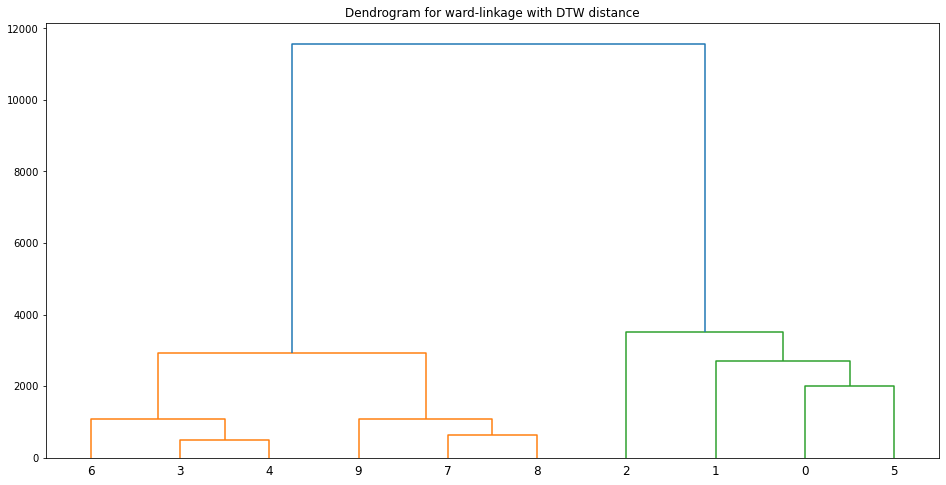

In [118]:
def hierarchical_clustering(dist_mat, dist_method, method='complete'):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with {dist_method} distance")
    plt.show()
    
    return Z

linkage_matrix = hierarchical_clustering(dtw_distance, "DTW", method='ward')

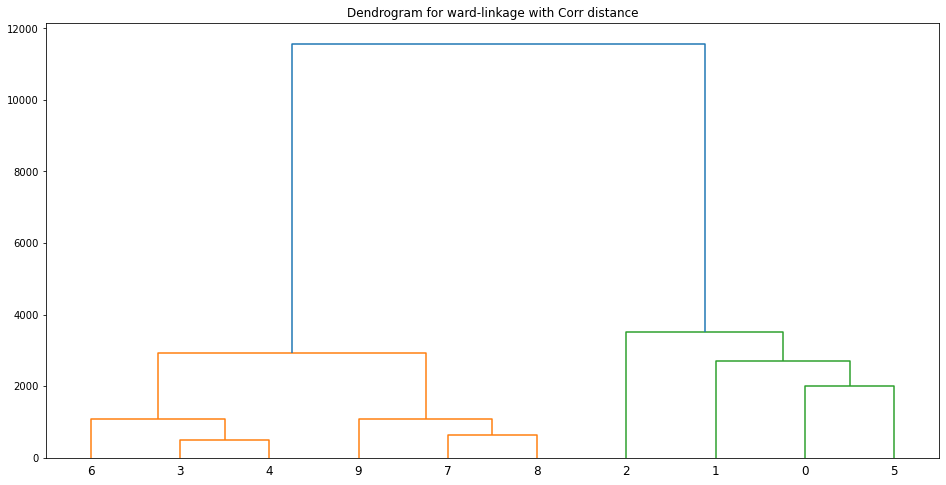

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 1.09205312e+03, 3.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.09505554e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.40000000e+01, 2.70888401e+03, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.92277585e+03, 6.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 3.52817406e+03, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.15706149e+04, 1.00000000e+01]])

In [119]:
hierarchical_clustering(corr_distance, "Corr", method='ward')

## Other dendograms

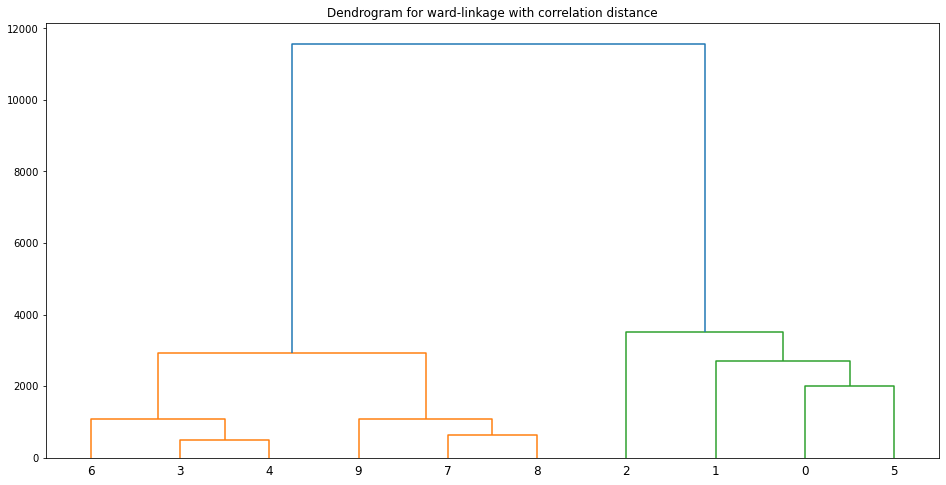

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 1.09205312e+03, 3.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.09505554e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.40000000e+01, 2.70888401e+03, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.92277585e+03, 6.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 3.52817406e+03, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.15706149e+04, 1.00000000e+01]])

In [97]:
hierarchical_clustering(dtw_distance, method='ward')

/srv/scratch/z3289452/mambaforge/envs/SymbolicDataAnalysis/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:446: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='average', metric='euclidean')


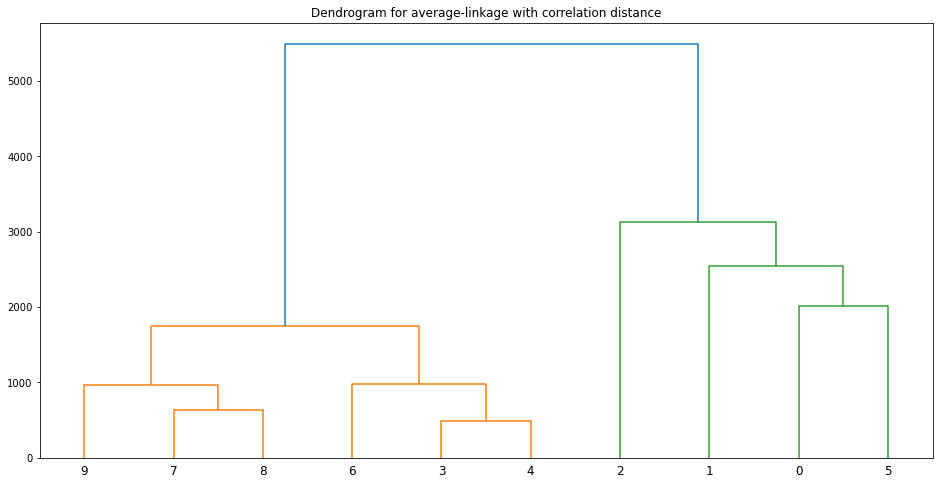

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 9.69800135e+02, 3.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 9.76362444e+02, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 1.75616148e+03, 6.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.50000000e+01, 2.54704100e+03, 3.00000000e+00],
       [2.00000000e+00, 1.60000000e+01, 3.12472722e+03, 4.00000000e+00],
       [1.40000000e+01, 1.70000000e+01, 5.49804210e+03, 1.00000000e+01]])

In [98]:
hierarchical_clustering(dtw_distance, method='average')

# Symbolic Data Based Clustering

In [102]:
# create symbolic data from timeseries
[station.shape for station in station_data]

[(371, 1),
 (372, 1),
 (371, 1),
 (372, 1),
 (372, 1),
 (372, 1),
 (371, 1),
 (367, 1),
 (369, 1),
 (371, 1)]

In [104]:
def get_symbols(ser):
    l=np.min(ser)
    u=np.max(ser)
    return ((l+u)/2, (u-l)/2)

station_symbols = [get_symbols(station) for station in station_data]

In [156]:
# @njit
def beta(a,b):
    assert (a>0 and b>0), "a and b must be > 0"
    
    def integrand(a,b):
        return lambda t: t**(a-1)*(1-t)**(b-1)
    
    return integrate(integrand(a,b), 0, 1)[0]

# @njit
def betainc(a,b,x):
    assert (a>0 and b>0), "a and b must be > 0"
    
    def integrand(a,b):
        return lambda t: t**(a-1)*(1-t)**(b-1)
    
    return integrate(integrand(a,b), 0, x)[0]

# beta distribution function 
# @jit(nopython=True)
def BetaPDF(t,a,b):
    if t<0 or t>1:
        return 0.
    else:
        return 1/beta(a,b)*t**(a-1)*(1-t)**(b-1)


# Mean quantile function
# @jit(nopython=True)
def mQTri(t,c,r,a,b):
    assert (a>=0 and b>=0), "a and b must be positive"
    if (a==1 and b==1):
        part1 = 2*r*t+c-r
        part2 = 4/3.*r*(sqrt(t) - sqrt(1-t) - t**2 + (1-t)**2)
    else:
        part1 = 2*r * BetaPDF(t,a,b) + c - r
        part2 = 2*r / beta(a,b) * ( sqrt(t) * ( beta(a+1/2,b) - betainc(a+1/2,b,t)  ) - sqrt(1-t) * betainc(a,b+1/2,t) )
    return part1 + part2    

##
## Assume the data are triangular distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
# @jit(nopython=True)
def MalTriTri(c1,r1,m1,c2,r2,m2):
    assert (m1>(c1-r1) and m1<(c1+r1)), "Mode m1 must be within [c1-r1,c1+r1]"
    assert (m2>(c2-r2) and m2<(c2+r2)), "Mode m2 must be within [c2-r2,c2+r2]"
    Index = ( (m1-c1)/r1 <= (m2-c2)/r2 )
  
    part0 = (c1-c2)**2 + 1/6.*((r1-r2)**2 + (m1-c1)**2 + (m2-c2)**2) - 5/3.*r1*r2
    if (Index):
        pt1A = c1-c2+r2
        pt1B = c1-c2+r1
        pt2 = (5 - (m1-c1)/r1)
        pt3 = (5 + (m2-c2)/r2)
        part4 = sqrt(r1*r2*(c1-m1+r1)*(m2-c2+r2))/2*(asin((m2-c2)/r2) - asin((m1-c1)/r1))
    else:
        pt1A = c1-c2-r2
        pt1B = c1-c2-r1    
        pt2 = (5 - (m2-c2)/r2)
        pt3 = (5 + (m1-c1)/r1)
        part4 = sqrt(r1*r2*(c2-m2+r2)*(m1-c1+r1))/2*(asin((m1-c1)/r1) - asin((m2-c2)/r2))
        
    part1 = 2*(m1-c1)*pt1A/3 - 2*(m2-c2)*pt1B/3
    part2 = sqrt(r1*r2*(m1-c1+r1)*(m2-c2+r2))/6 * pt2
    part3 = sqrt(r1*r2*(c1-m1+r1)*(c2-m2+r2))/6 * pt3
    return sqrt(part0 + part1 + part2 + part3 + part4)

##
## Assume the data are triangular distributed over the 1st interval
## Assume the data are triangular distributed over the 2nd interval
##
## We consider (m1-c1+r1)/(2*r1) to be beta distributed with parameters a1 and b1
## If a1=b1=1 then the mode is uniformly distributed on [c1-r1, c1+r1]
## We consider (m2-c2+r2)/(2*r2) to be beta distributed with parameters a2 and b2
## If a2=b2=1 then the mode is uniformly distributed on [c2-r2, c2+r2]

def M1MalTriTriIntegrand(c1,r1,a1,b1,c2,r2,a2,b2):
    return lambda t: (mQTri(t, c1, r1, a1, b1) - mQTri(t, c2, r2, a2, b2) )**2

def M1MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    assert (a1>=0 and b1>=0), "a and b must be positive"
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a1==1 and b1==1 and a2==1 and b2==1):
        return sqrt( (c1-c2)**2 - (20*math.pi-71)/45.*(r2-r1)**2 )
    else:
        return sqrt(integrate(M1MalTriTriIntegrand(c1,r1,a1,b1,c2,r2,a2,b2), 0, 1)[0])
  
def M2MalTriTriDblIntegrand(c1,r1,a1,b1,c2,r2,a2,b2):
    return lambda m1, m2: MalTriTri(c1, r1, m1, c2, r2, m2)**2 * BetaPDF((m1-c1+r1)/(2*r1), a1, b1) / (2*r1) * BetaPDF((m2-c2+r2)/(2*r2), a2, b2) / (2*r2)

def M2MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2):
    assert (a1>=0 and b1>=0), "a and b must be positive"
    assert (a2>=0 and b2>=0), "a and b must be positive"
    if (a1==1 and b1==1 and a2==1 and b2==1):
        return sqrt( (c1-c2)**2 + 2*(r1**2+r2**2)/9 + (8*math.pi/9 - 142/45)*r1*r2 )
    else:
        return sqrt( dblquad(M2MalTriTriDblIntegrand(c1,r1,a1,b1,c2,r2,a2,b2) , c2-r2, c2+r2, c1-r1, c1+r1 )[0] )
    

In [157]:
# compute distance matrix based on symbols
def symbol_dist_matrix(symbols, scenario="XunifYunif", method=1, a1=1., b1=1., a2=1., b2=1.):
    # Initialize distance matrix
    n_series = len(symbols)
    symbol_distance = np.zeros(shape=(n_series, n_series))
    
    # get distance function based on scenario and method
    if scenario=="XunifYunif":
        distfn = md.MalUnifUnif
    elif scenario=="XsymYsym" and method==1:
        distfn = lambda c1, r1, c2, r2: md.M1MalTriTri(c1,r1,1.,1.,c2,r2,1.,1.) 
    elif scenario=="XsymYsym" and method==2:
        distfn = lambda c1, r1, c2, r2: md.M2MalTriTri(c1,r1,1.,1.,c2,r2,1.,1.)
    elif scenario=="XskewYskew" and method==1:
        distfn = lambda c1, r1, c2, r2: M1MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2) 
    elif scenario=="XskewYskew" and method==2:
        distfn = lambda c1, r1, c2, r2: M2MalTriTri(c1,r1,a1,b1,c2,r2,a2,b2) 
    
    # Build distance matrix
    for i in range(n_series):
        for j in range(n_series):
            x = symbols[i]
            y = symbols[j]
            if i != j:
                dist = distfn(x[0], x[1], y[0], y[1])
                symbol_distance[i, j] = dist
    
    return symbol_distance

/srv/scratch/z3289452/mambaforge/envs/SymbolicDataAnalysis/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


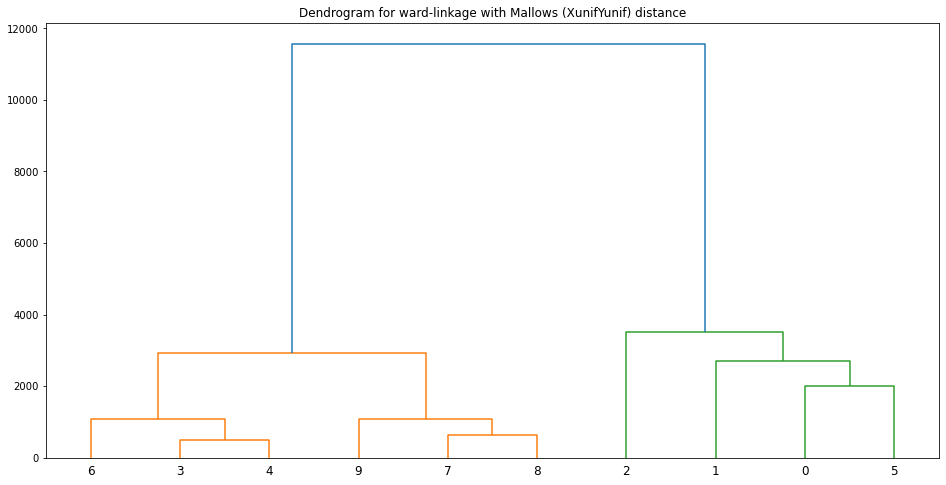

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 1.09205312e+03, 3.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.09505554e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.40000000e+01, 2.70888401e+03, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.92277585e+03, 6.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 3.52817406e+03, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.15706149e+04, 1.00000000e+01]])

In [120]:
# XunifYunif
dist_matrix = symbol_dist_matrix(station_symbols)
hierarchical_clustering(dist_matrix, "Mallows (XunifYunif)", method='ward')

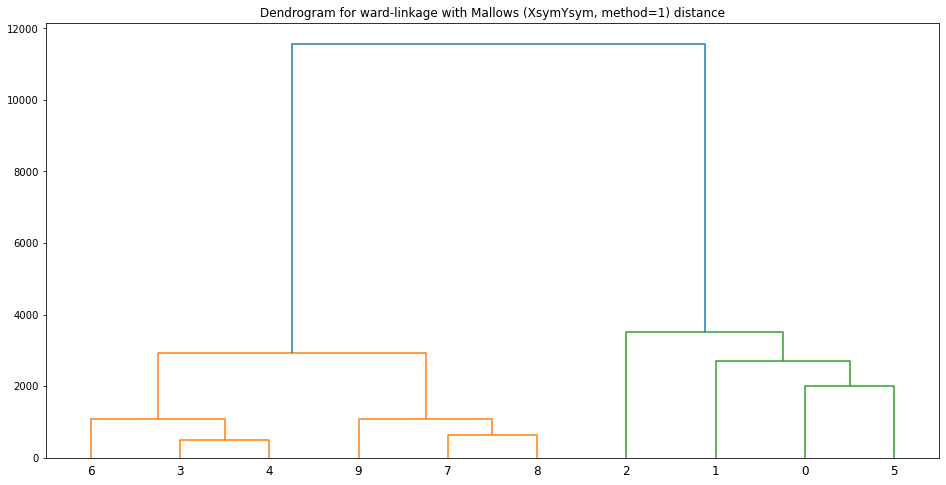

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 1.09205312e+03, 3.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.09505554e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.40000000e+01, 2.70888401e+03, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.92277585e+03, 6.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 3.52817406e+03, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.15706149e+04, 1.00000000e+01]])

In [122]:
# XsymYsym
dist_matrix = symbol_dist_matrix(station_symbols, scenario="XsymYsym", method=1)
hierarchical_clustering(dist_matrix, "Mallows (XsymYsym, method=1)", method='ward')

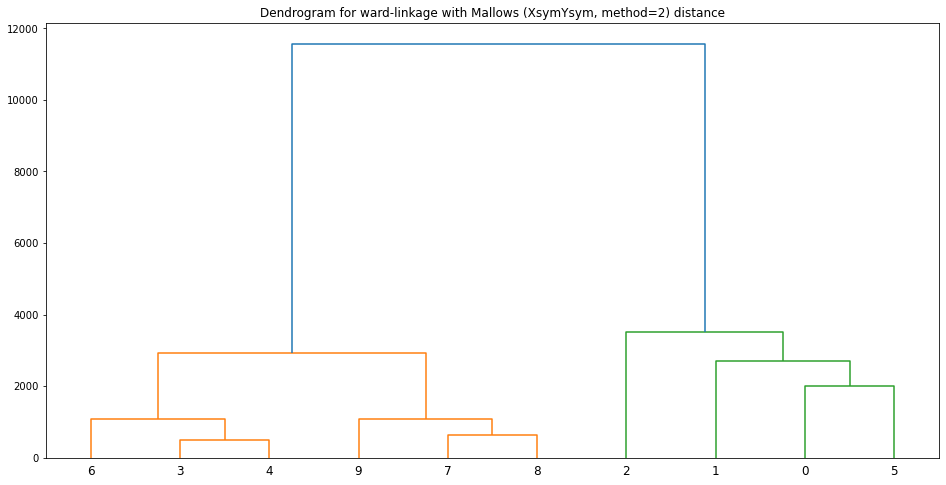

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 1.09205312e+03, 3.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.09505554e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.40000000e+01, 2.70888401e+03, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.92277585e+03, 6.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 3.52817406e+03, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.15706149e+04, 1.00000000e+01]])

In [165]:
# XsymYsym
dist_matrix = symbol_dist_matrix(station_symbols, scenario="XsymYsym", method=2)
hierarchical_clustering(dist_matrix, "Mallows (XsymYsym, method=2)", method='ward')

/srv/scratch/z3289452/mambaforge/envs/SymbolicDataAnalysis/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


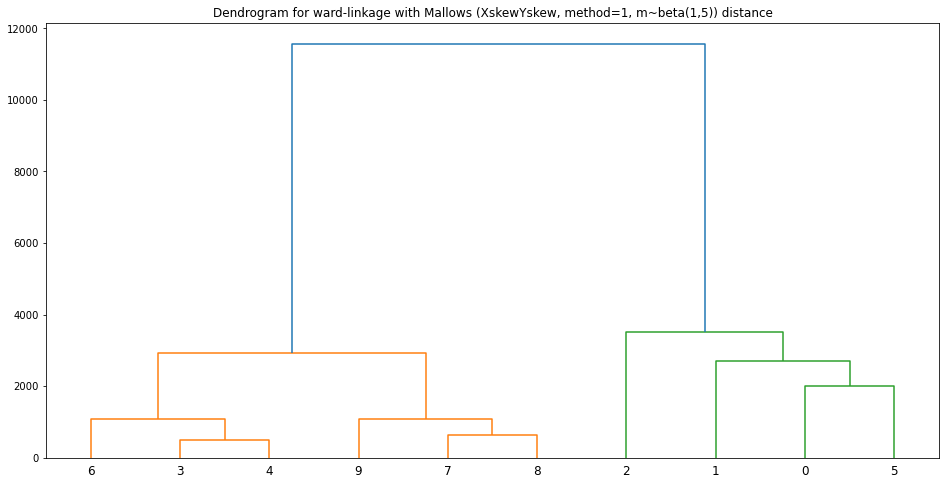

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 1.09205312e+03, 3.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.09505554e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.40000000e+01, 2.70888401e+03, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.92277585e+03, 6.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 3.52817406e+03, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.15706149e+04, 1.00000000e+01]])

In [158]:
# XskewYskew
dist_matrix = symbol_dist_matrix(station_symbols, scenario="XskewYskew", method=1, a1=1.,b1=5.,a2=1.,b2=5.)
hierarchical_clustering(dist_matrix, "Mallows (XskewYskew, method=1, m~beta(1,5))", method='ward')

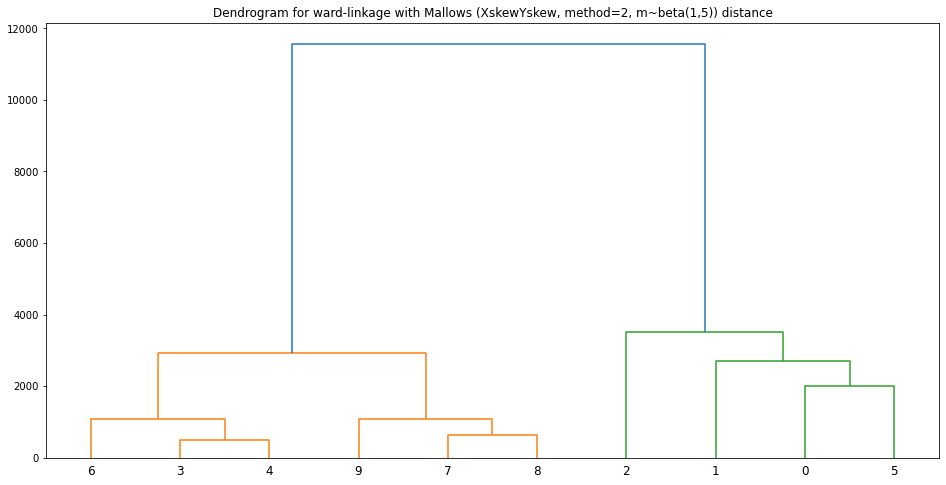

array([[3.00000000e+00, 4.00000000e+00, 4.85299628e+02, 2.00000000e+00],
       [7.00000000e+00, 8.00000000e+00, 6.28162549e+02, 2.00000000e+00],
       [6.00000000e+00, 1.00000000e+01, 1.09205312e+03, 3.00000000e+00],
       [9.00000000e+00, 1.10000000e+01, 1.09505554e+03, 3.00000000e+00],
       [0.00000000e+00, 5.00000000e+00, 2.01261832e+03, 2.00000000e+00],
       [1.00000000e+00, 1.40000000e+01, 2.70888401e+03, 3.00000000e+00],
       [1.20000000e+01, 1.30000000e+01, 2.92277585e+03, 6.00000000e+00],
       [2.00000000e+00, 1.50000000e+01, 3.52817406e+03, 4.00000000e+00],
       [1.60000000e+01, 1.70000000e+01, 1.15706149e+04, 1.00000000e+01]])

In [164]:
# XskewYskew
dist_matrix = symbol_dist_matrix(station_symbols, scenario="XskewYskew", method=2, a1=1.,b1=5.,a2=1.,b2=5.)
hierarchical_clustering(dist_matrix, "Mallows (XskewYskew, method=2, m~beta(1,5))", method='ward')

In [2]:
cat_dam = pd.read_csv('/srv/ccrc/data11/z3289452/BOM_HQ_precip/prcphq.068016.daily.txt',skiprows=1,header=None,sep='\s+',
                      na_values=99999.9,index_col=0,parse_dates=True,names=["date","prcp"])

In [3]:
cat_dam

,prcp
date,
1904-01-01,0.0
1904-01-02,7.6
1904-01-03,0.0
1904-01-04,0.0
1904-01-05,0.0
...,...
2013-01-27,45.8
2013-01-28,10.0
2013-01-29,100.6


<AxesSubplot:xlabel='date'>

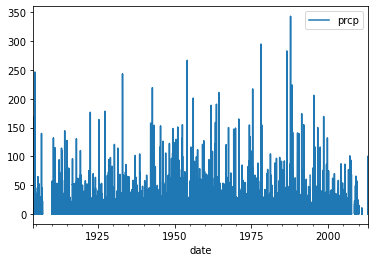

In [4]:
cat_dam.plot()

In [5]:
plt.plot(cat_dam.index, cat_dam.prcp)

In [6]:
plt.hist(cat_dam.prcp)

(array([3.6469e+04, 4.8700e+02, 1.0300e+02, 5.3000e+01, 2.4000e+01,
        8.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([  0.  ,  34.32,  68.64, 102.96, 137.28, 171.6 , 205.92, 240.24,
        274.56, 308.88, 343.2 ]),
 <BarContainer object of 10 artists>)

In [7]:
plt.plot([0,1,12,3,5], [5,4,2,66,7])